# Headline generation with finetuned pre-trained models(mBART and T5)



#### Contents

1. [Preparing Environment and Importing Libraries](#section01)
2. [Preparing the Dataset for data processing: Class](#section02)
3. [Fine Tuning the Model: Function](#section03)
4. [Validating the Model Performance: Function](#section04)
5. [Main Function](#section05)
    * [Creation of Dataset and Dataloader](#section503)
    * [Neural Network and Optimizer](#section504)
    * [Validation and generation of Summary](#section506)
6. [Examples of the Summary Generated from the model](#section06)

In [1]:
!pip install transformers -q
!pip install sentencepiece
!pip install rouge_score
# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 4.4 MB 32.6 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
     |████████████████████████████████| 86 kB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 12.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.translate import bleu
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import json
import string
import numpy as np
import pandas as pd
import re
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer

from tqdm.notebook import tqdm
# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MBartTokenizer, MBartForConditionalGeneration

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
# Checking out the GPU we have access to. This is output is from the google colab version. 
!nvidia-smi

Sun Jun 19 18:46:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

#### Useful insights

In [6]:
ria_dataset = "ria_2k.json"
ria_df = pd.read_json(ria_dataset)

# gazeta_dataset = "gazeta_2k.json"
# gazeta_df = pd.read_json(gazeta_dataset)

# rbc_dataset = "rbc_2k.json"
# rbc_2k = pd.read_json(rbc_dataset)

In [ ]:
df = rbc_2k.transpose()

In [ ]:
df['articles_length'] = df['article_text'].apply(lambda x : len(x.split()))
df['headline_length'] = df['headline'].apply(lambda x : len(x.split()))

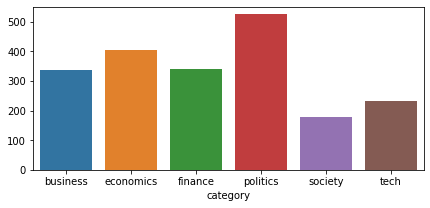

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
category_sizes = df.groupby('category').size()
plt.figure(figsize=(7,3))
sns.barplot(x=category_sizes.index, y= category_sizes)
plt.show()

In [ ]:
category_length = df.groupby('category',0).agg( {'articles_length':'mean', 'headline_length':'mean'} )
category_length

,articles_length,headline_length
category,,
business,584.866864,8.778107
economics,530.952970,9.012376
finance,611.126844,8.920354
politics,438.087786,9.263359
society,386.508475,9.000000
tech,534.527897,8.579399


In [ ]:
pd.melt(category_length,ignore_index=False).groupby('variable').mean()

,value
variable,
articles_length,514.345139
headline_length,8.925599


In [12]:
class Prepare_Dataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.summarization_target = self.data.iloc[:,0] # Assuming that the first column should always be the inteded task target
        self.article_text = self.data.iloc[:,1]

    def __len__(self):
        return len(self.summarization_target)

    def __getitem__(self, index):
        article_text = str(self.article_text[index])
        article_text = ' '.join(article_text.split())

        summarization_target = str(self.summarization_target[index])
        summarization_target = ' '.join(summarization_target.split())

        source = self.tokenizer.batch_encode_plus([article_text], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([summarization_target], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

<a id='section03'></a>
### Fine Tuning the Model: Function

Training function that trains the model on the training dataset created above, specified number of times (EPOCHs), An epoch defines how many times the complete data will be passed through the network. 

This function is called in the `main(,)`

Following events happen in this function to fine tune the neural network:
- The epoch, tokenizer, model, device details, testing_ dataloader and optimizer are passed to the `train ()` when its called from the `main(,)`
- The dataloader passes data to the model based on the batch size.
- `language_model_labels` are calculated from the `target_ids` also, `source_id` and `attention_mask` are extracted.
- The model outputs first element gives the loss for the forward pass. 
- Loss value is used to optimize the weights of the neurons in the network.

In [13]:
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

<a id='section04'></a>
### Validating the Model Performance: Function

During the validation stage we pass the unseen data(Testing Dataset), trained model, tokenizer and device details to the function to perform the validation run. This step generates new summary for dataset that it has not seen during the training session. 

This function is called in the `main()`

This unseen data is the 20% of `rbc_dataset.json` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. We use the generate method for generating new text for the summary. 

It depends on the `Beam-Search coding` method developed for sequence generation for models with LM head. 

The generated text and originally summary are decoded from tokens to text and returned to the `main()`

In [14]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actual_summaries = []
    actual_text = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            source_article = [tokenizer.decode(a, skip_special_tokens=True, clean_up_tokenization_spaces=True)for a in ids]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actual_summaries.extend(target)
            actual_text.extend(source_article)
    return predictions, actual_summaries, actual_text

In [15]:
# Selecting the needed columns only.
def select_pair(column_one, column_two, dataset):
    df = pd.read_json(dataset)
    df = df.transpose()
    df = df[[column_one, column_two]]
    return df

In [16]:
def main(target_source_pair):

    TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    VAL_EPOCHS = 1 
    LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    SEED = 777               # random seed (default: 42)
    MAX_LEN = 512
    SUMMARY_LEN = 150 

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(SEED) # pytorch random seed
    np.random.seed(SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    MODEL_NAME = 'cointegrated/rut5-base-absum'

    rut5_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
    model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    model = model.to(device)


    train_size = 0.8
    df = target_source_pair
    train_dataset=df.sample(frac=train_size, random_state = SEED).reset_index(drop=True)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    training_set = Prepare_Dataset(train_dataset, rut5_tokenizer, MAX_LEN, SUMMARY_LEN)
    val_set = Prepare_Dataset(val_dataset, rut5_tokenizer, MAX_LEN, SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)


    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(TRAIN_EPOCHS):
        train(epoch, rut5_tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(VAL_EPOCHS):
        predictions, actual_summaries, actual_text = validate(epoch, rut5_tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'gen_summary':predictions,'ref_summary':actual_summaries, 'full_text':actual_text})
        final_df.to_csv("./outputs/t5/summaries_t5_{}_{}.csv".format('_'.join(list(df.columns)), dataset.split('.')[0]))
        print('Output Files generated for review')

In [ ]:
summarization_target = 'title'
source_text = 'text'
dataset = ria_dataset
target_source_pair = select_pair(summarization_target, source_text, dataset)
if __name__ == '__main__':
    main(target_source_pair)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


FULL Dataset: (2000, 2)
TRAIN Dataset: (1600, 2)
TEST Dataset: (400, 2)
Initiating Fine-Tuning for the model on our dataset


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  3.7699508666992188
Epoch: 0, Loss:  1.6562714576721191
Epoch: 1, Loss:  1.6829297542572021
Epoch: 1, Loss:  2.838766574859619
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Completed 100
Output Files generated for review


In [ ]:
df_summary = pd.read_csv('./outputs/summaries_t5_headline_article_text.csv', index_col=0)
no_duplicates = df_summary[~df_summary.gen_summary.isin(df_summary.ref_summary)]

In [ ]:
len(df_summary.index), len(no_duplicates.index)

(321, 317)

## **mBART Pre-trained model**

In [7]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

In [8]:
def gen_batch(inputs, batch_size):
    batch_start = 0
    while batch_start < len(inputs):
        yield inputs[batch_start: batch_start + batch_size]
        batch_start += batch_size

In [9]:
def predict(
    tokenizer,
    model,
    inputs,
    refrences,
    max_article_tokens_count=1000,
    max_refrence_tokens_count=100,
    use_cuda=True,
    batch_size=4
):

    device = torch.device("cuda:0") if use_cuda else torch.device("cpu")
    
    predictions = []
    for batch in tqdm(gen_batch(inputs, batch_size)):
        input_ids = tokenizer.prepare_seq2seq_batch(
            batch,
            src_lang="ru_RU",
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_article_tokens_count)["input_ids"].to(device)
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_refrence_tokens_count + 2,
            no_repeat_ngram_size=3,
            num_beams=5,
            top_k=0
        )
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        predictions.extend(summaries)

    summary_df = pd.DataFrame({'gen_summary':predictions,'ref_summary':refrences, 'full_text':inputs})
    return summary_df

In [17]:
summarization_target = 'title'
source_text = 'text'
dataset = ria_dataset
target_source_pair = select_pair(summarization_target, source_text, dataset)
inputs, refrences = list(target_source_pair[source_text]), list(target_source_pair[summarization_target])
df_summary = predict(tokenizer, model, inputs, refrences)

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3557: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [20]:
df_summary.to_csv("./outputs/mbart/summaries_mbart_{}_{}_{}.csv".format(summarization_target, source_text , dataset.split('.')[0]))

# **Evaluation of T5 and mBART summaries**

In [ ]:
from evaluate import present_metric_results, calculate_Bleu_Score, calculate_Rouge_Score, evalute_sample_from_dataset
from plot_eval import plot_rouge, plot_bleu

### **Evaluating T5 summaries**

In [ ]:
# mbart_folder = '../outputs/mbart/'
# from os import walk

# f = []
# for (dirpath, dirnames, csv_datafiles) in walk(mbart_folder):
#     for csv_file in csv_datafiles:
#         present_metric_results("../outputs/mbart/{}".format(csv_file))

In [ ]:
# t5_folder = '../outputs/t5/'
# from os import walk

# f = []
# for (dirpath, dirnames, csv_datafiles) in walk(t5_folder):
#     for csv_file in csv_datafiles:
#         present_metric_results("../outputs/t5/{}".format(csv_file))

In [ ]:
# mbart_folder = '../outputs/t5/'
# from os import walk

# f = []
# for (dirpath, dirnames, csv_datafiles) in walk(mbart_folder):
#     for csv_file in csv_datafiles:
#         present_metric_results("../outputs/mbart/{}".format(csv_file))

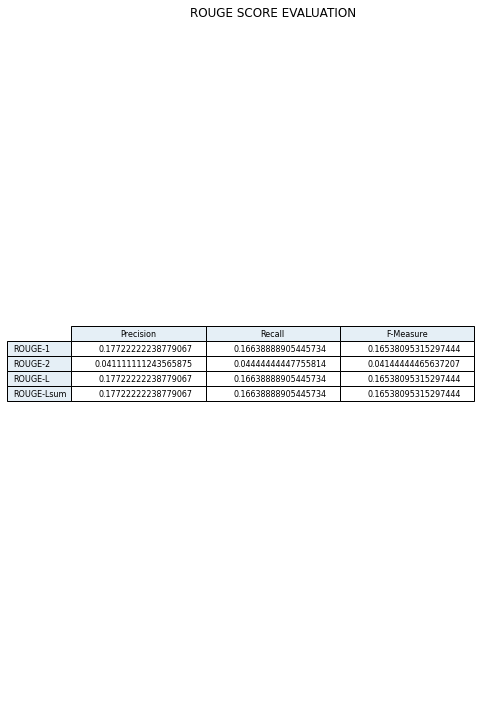

In [ ]:
plot_rouge(rouge_eval)

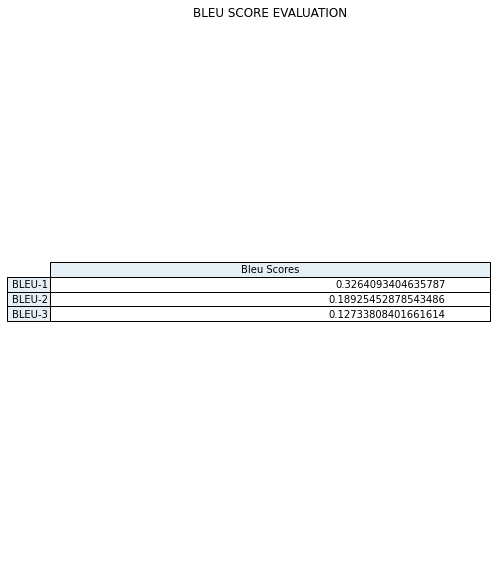

In [ ]:
plot_bleu(bleu_scores)

### **Evaluating mBART summaries**

In [ ]:
summary_datafile = 'mbart_gen_summary_ref_summary_full_text.csv'

In [ ]:
bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, rougeLsum_scores = evalute_sample_from_dataset(summary_datafile, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Final Blue Scores [[0.22734489 0.09983469 0.05525172]]
Final ROUGE1 Scores [[0.1175     0.11003175 0.10901058]]
Final ROUGE2 Scores [[0.02888889 0.02944444 0.02844444]]
Final ROUGEL Scores [[0.1175     0.11003175 0.10901058]]
Final ROUGELsum Scores [[0.1175     0.11003175 0.10901058]]


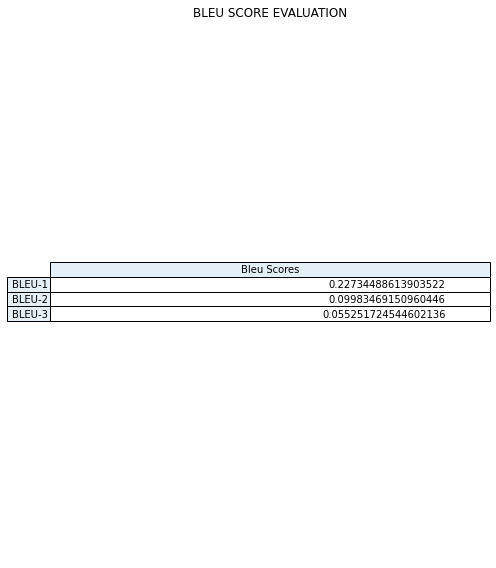

In [ ]:
plot_bleu(bleu_scores)

In [ ]:
rouge_eval = []
rouge_eval.append(rouge1_scores[0].tolist())
rouge_eval.append(rouge2_scores[0].tolist())
rouge_eval.append(rougeL_scores[0].tolist())
rouge_eval.append(rougeLsum_scores[0].tolist())

rouge_eval = (np.array(rouge_eval))

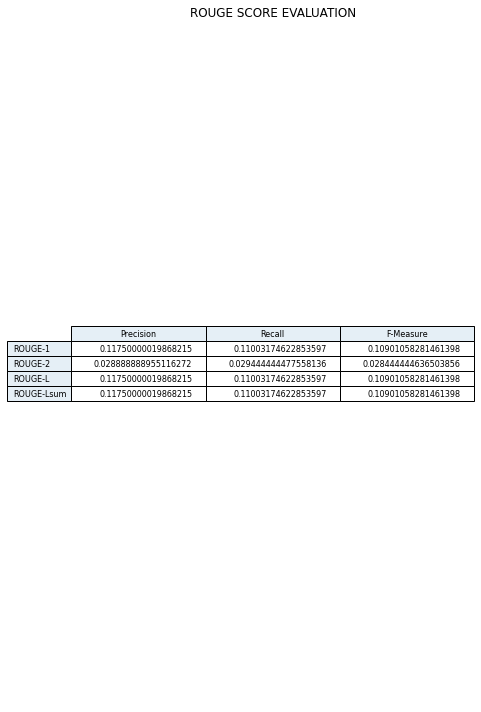

In [ ]:
plot_rouge(rouge_eval)